##### In the present work we were commissioned by the Children, Young People and Education (CAYE)
##### Committee to explore data science techniques to carry out an independent analysis of 650 responses
##### to a consultation gathering opinions on a recent Welsh Government Bill-the Children (Abolition of
##### Defence of Reasonable Punishment) (Wales) Bill (“the Bill”). 
##### This notebook describes the methods used in our analysis.
##### More details on the background of the cosultation can be found here:
http://senedd.assembly.wales/mgIssueHistoryHome.aspx?IId=24674
    

##### The techniques used in our analysis include  word collocation and tf-idf for salient phrases detection
##### We also pulled out the context surrounding the salient phrases
##### Author: Dr Chaitanya Joshi

##### Step 1:Import the necessary libraries

##### There are various online resources available to analyse free text data using NLP techniques. Some of the concepts used in the notebook are covered here:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://buhrmann.github.io/tfidf-analysis.html

https://radimrehurek.com/gensim/models/phrases.html

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


import re
import numpy as np
import pandas as pd
from pprint import pprint


import pandas as pd
import numpy as np
import glob
import random
import string
import pickle


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns


import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn





import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases

import operator




from wordcloud import WordCloud


import os.path






# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from contractions import contractions_dict
import unicodedata






from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
import re
import string

import scipy.stats as ss







import matplotlib










##### Step 2: Preliminaries

##### Update the stop-words list
##### Specify the required font size etc

In [ ]:
# Create Stemming and Lemmatizer objects
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()


stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','could','would','should'])

                
del_list=['do','does','not','no','dont','wont']


stop_words=[e for e in stop_words if e not in del_list]


#Default font is not always the optimal choice
fnt_sz=20

fnt_sz_title=25

fnt_sz_tk=15

fnt_sz_tk_big=12

fnt_sz_legend_big=12 
fig_siz=(10,5)
fig_siz_big=(15,10)

#Destination to storing results
path_to_results='./results/figures/'
path_to_file='./results/'

#One can also tweak the font type etc in matplotlib
plt.style.use('fivethirtyeight')#seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
#plt.rcParams['axes.tickweight'] = 'bold'
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12




##### Step 3: Load the dataset

##### Specify the required columns
##### load the dataset
##### Perform initial data wrangling

In [5]:

# Load the data:

# The following needs to be tweaked if the dataset has different columns
sep='+'*100
consultn_data=pd.read_pickle(path_to_file+'consultn_data_complete.pl')

print(consultn_data['UserType'].value_counts())
print(sep)
print('Total number of responses received is {}'.format(consultn_data['UserType'].shape[0]))
print(sep)
print('Number of responses in support or otherwise for the Bill')
print(pd.DataFrame(consultn_data.groupby(['UserType','BillSupport'])['BillSupport'].apply(len)))


reduced_columns=['Translation', 'ProfPersonal','Q2 Are you over 13 years old?',\
                 'Postcode-Personal', 'WhatLangSubmit-personal', 'Are you represening an Org',\
                 'UserType', 'Q6 Organisation - Eng', 'BillSupport',\
                 'Q10 12 Please outline your reasons for your answer to question',\
                 'Q11 13 Do you think there is a need for legislation to deliver',\
                 'Q12 21 Do you have any comments about any potential barriers t',\
                 'Q13 22 Do you think the Bill takes account of these potential ',\
                 'Q14 31 Do you think there are there any unintended consequence',\
                 'Q15 41 Financial Implications', 'Q16 51 Other Comments']


smaller_colmns=[ 'Postcode-Personal','UserType', 'BillSupport',\
                 'Q10 12 Please outline your reasons for your answer to question',\
                 'Q11 13 Do you think there is a need for legislation to deliver',\
                 'Q12 21 Do you have any comments about any potential barriers t',\
                 'Q13 22 Do you think the Bill takes account of these potential ',\
                 'Q14 31 Do you think there are there any unintended consequence',\
                 'Q15 41 Financial Implications', 'Q16 51 Other Comments']



df_responses_type=pd.DataFrame(consultn_data.groupby(['BillSupport','UserType'])['BillSupport'].apply(len))

df_responses_type=df_responses_type.rename(columns={'BillSupport':'Number of responses'})
df_responses_type=df_responses_type.reset_index()

df_responses_type['Number of responses(%)']=np.round(100*df_responses_type['Number of responses']/\
df_responses_type['Number of responses'].sum(),1)

Individual      562
Organisation     59
Professional     29
Name: UserType, dtype: int64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Total number of responses received is 650
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of responses in support or otherwise for the Bill
                                BillSupport
UserType     BillSupport                   
Individual   No                         381
             Partly                      20
             Yes                        161
Organisation Don't have a view            2
             No                           5
             Yes                         52
Professional No                           4
             Yes                         25


##### Step 3.1: Overall support or otherwise for the Bill (cumulative for different user types)
##### Support for the Bill for different user types
##### The following should be tweaked to allow for different column names

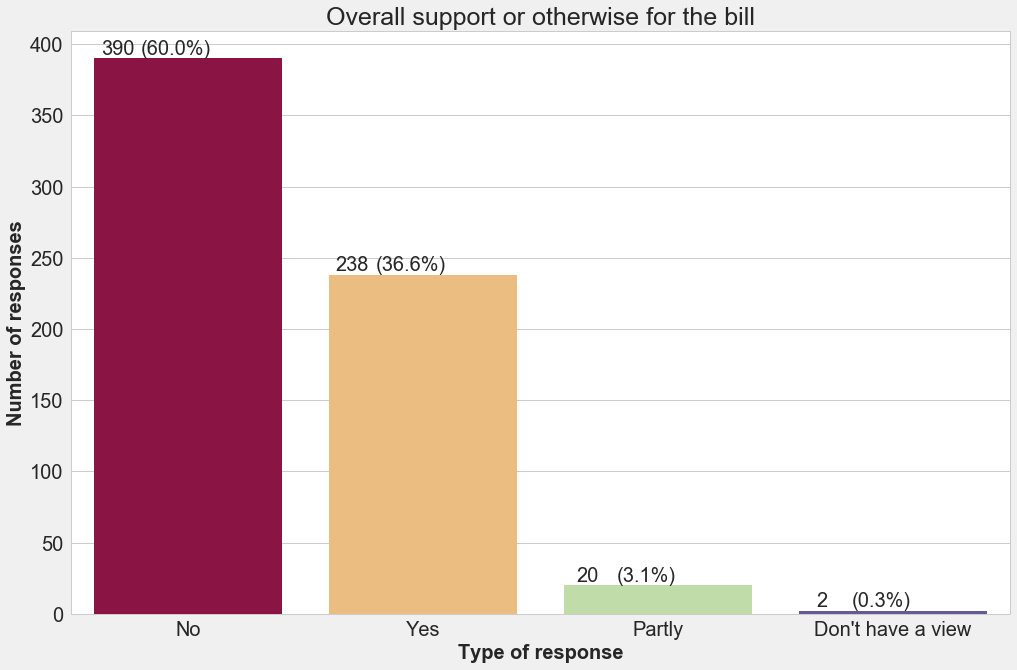

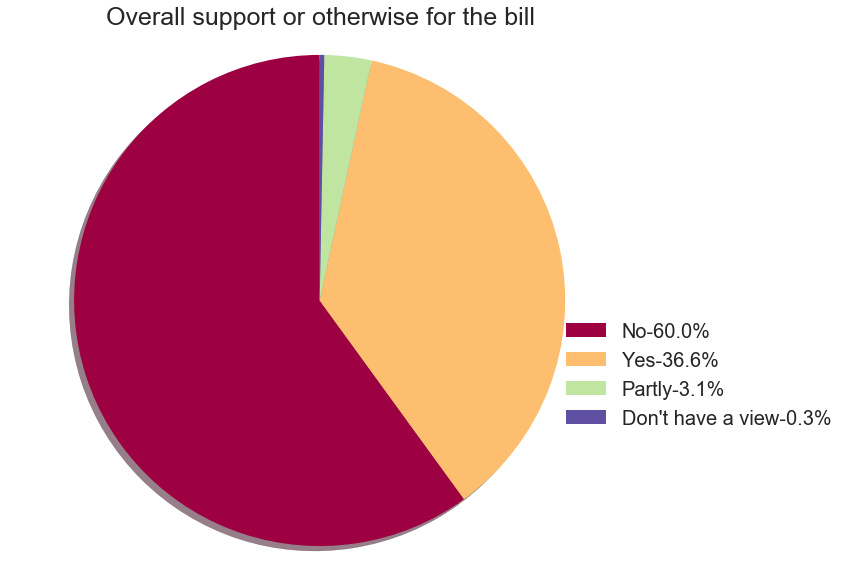

In [6]:
df_responses_combined_alltype=df_responses_type.groupby('BillSupport')['Number of responses','Number of responses(%)'].apply(sum).\
sort_values(by='Number of responses',ascending=False).reset_index()


cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
own_palette = sns.color_palette(colors)
plt.figure(figsize=fig_siz_big)


sns.set(style='whitegrid')
sns.set_color_codes('dark')
ax=sns.barplot(x='BillSupport',y='Number of responses',data=df_responses_combined_alltype,palette=own_palette,ci=None)
    
plt.title('Overall support or otherwise for the bill', fontsize=fnt_sz_title) 
plt.xlabel('Type of response', fontsize = fnt_sz)
plt.ylabel('Number of responses', fontsize = fnt_sz)
plt.xticks(fontsize=fnt_sz)
plt.yticks(fontsize=fnt_sz)
plt.legend(fontsize=fnt_sz,loc='best')

totals=[]

for i in ax.patches:
    totals.append(i.get_height())
    
totals=[x for x in totals  if ~np.isnan(x)]
    

    
total=sum(totals)



for i in ax.patches:
    if ~np.isnan(i.get_height()):
        ax.text(i.get_x()+0.1,i.get_height()+0.04,str(int(i.get_height())),ha = 'center',va='bottom',\
                fontsize=fnt_sz)
        ax.text(i.get_x()+0.35,i.get_height()+0.095,'('+str(round((i.get_height()/total)*100,1))+'%)',ha = 'center', \
                va='bottom',fontsize=fnt_sz)

# save the figure as .eps file
#fig_multi_tags = ax.get_figure()
plt.savefig(path_to_results+'response_type_overall_support_bar_chart.png')
plt.show()


df_responses_type.groupby(['UserType','BillSupport'])['Number of responses','Number of responses(%)'].\
apply(sum).sort_values(by='Number of responses(%)',ascending=False).\
to_html(path_to_results+'user_support.html')

df_responses_combined_alltype.to_html(path_to_results+'all_responses_type.html')



df_responses_combined_alltype['Number of responses(%)']=df_responses_combined_alltype['Number of responses(%)'].\
apply(lambda x: np.round(x,1))



%matplotlib inline
#credit https://matplotlib.org/devdocs/gallery/pie_and_polar_charts/pie_demo2.html#sphx-glr-gallery-pie-and-polar-charts-pie-demo2-py


# Make square figures and axes
plt.figure(figsize=(10,10))



labels=df_responses_combined_alltype['BillSupport']+str('-')+df_responses_combined_alltype['Number of responses(%)'].astype(str)+'%'
patches, texts = plt.pie(df_responses_combined_alltype['Number of responses(%)'], colors=colors,startangle=90,shadow=True)
plt.title('Overall support or otherwise for the bill', fontsize=fnt_sz_title) 
plt.legend(patches, labels, loc="top left",fontsize=fnt_sz)
plt.legend(patches,labels, bbox_to_anchor=(1.5,0.35), loc="bottom right",bbox_transform=\
           plt.gcf().transFigure,fontsize=fnt_sz)
plt.legend(patches,labels, bbox_to_anchor=(1.25,0.5), loc="upper right",bbox_transform=\
           plt.gcf().transFigure,fontsize=fnt_sz)
plt.axis('equal')
plt.savefig(path_to_results+'response_type_overall_support_pie_chart.png',bbox_inches="tight")
plt.show()



##### Step 3.2: Support or otherwise for the Bill for different user types (fraction of overall responses)

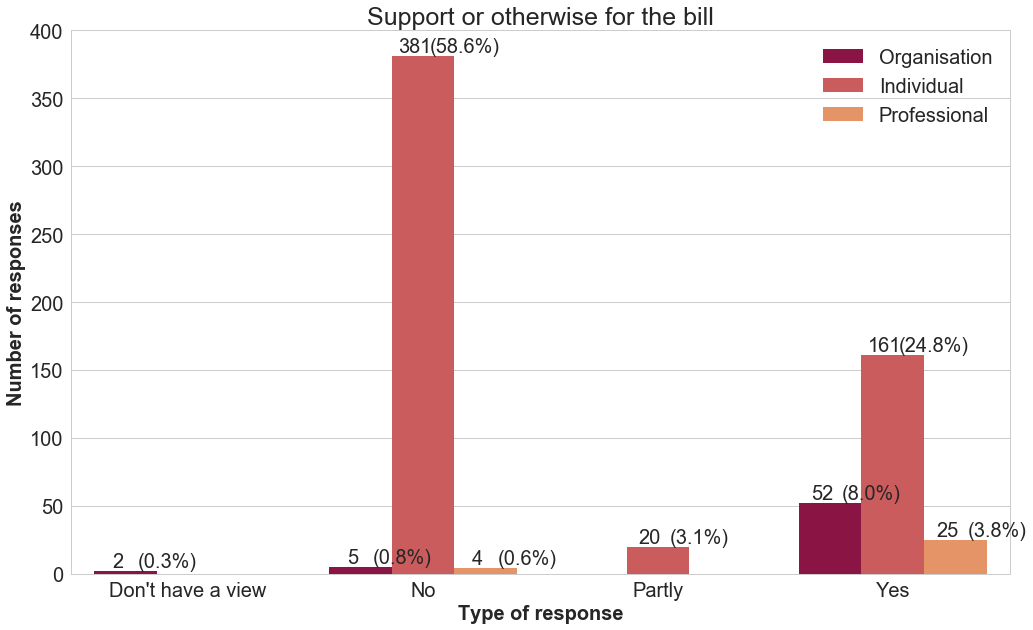

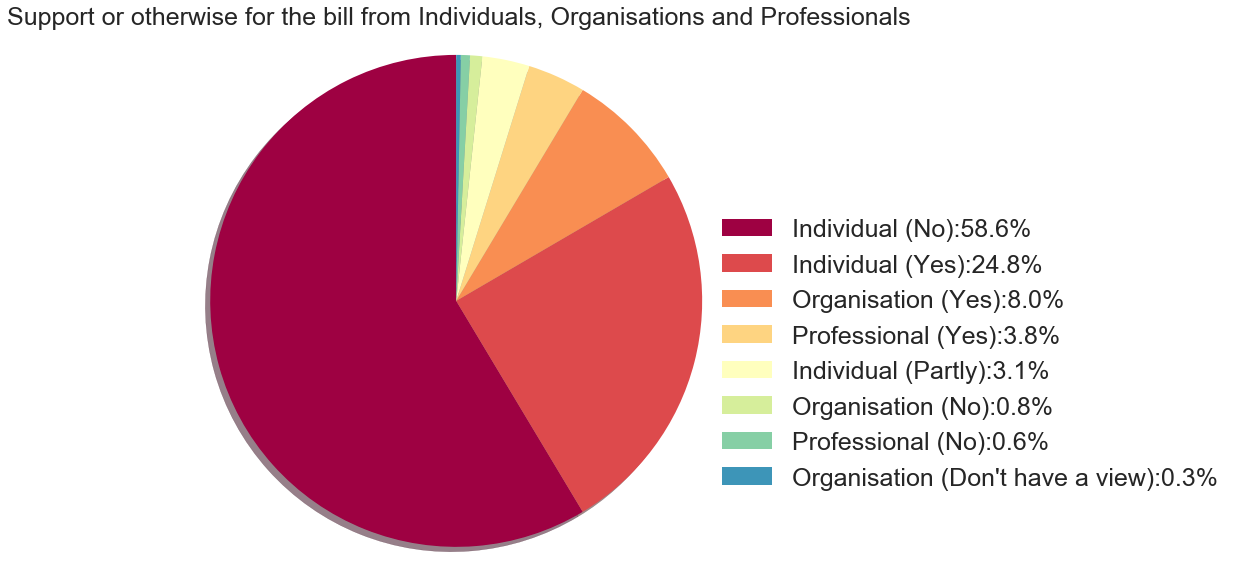

In [7]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

own_palette = sns.color_palette(colors)

plt.figure(figsize=fig_siz_big)
ax=sns.barplot(x='BillSupport',y='Number of responses', hue="UserType", data=df_responses_type,palette=own_palette)#,size=4, aspect=2) 
plt.title('Support or otherwise for the bill', fontsize=fnt_sz_title) 
plt.xlabel('Type of response', fontsize = fnt_sz)
plt.ylabel('Number of responses', fontsize = fnt_sz)
plt.xticks(fontsize=fnt_sz)
plt.yticks(fontsize=fnt_sz)
plt.legend(fontsize=fnt_sz,loc='best')
    
totals=[]

for i in ax.patches:
    totals.append(i.get_height())
    
totals=[x for x in totals  if ~np.isnan(x)]
    

    
total=sum(totals)


for i in ax.patches:
    if ~np.isnan(i.get_height()):
        ax.text(i.get_x()+0.1,i.get_height()+0.035,str(int(i.get_height())),ha = 'center', \
                va='bottom',fontsize=fnt_sz)
        ax.text(i.get_x()+0.31,i.get_height()+0.05,'('+str(round((i.get_height()/total)*100,1))+'%)',ha = 'center', \
                va='bottom',fontsize=fnt_sz)
plt.savefig(path_to_results+'response_type_support_bar_chart.png')
plt.show()


df_responses_type.groupby(['UserType','BillSupport'])['Number of responses','Number of responses(%)'].\
apply(sum).to_excel(path_to_results+'bill_support.xlsx')



df_responses_type_copy=df_responses_type.copy()
df_responses_type_copy['Percentage']=np.round(100*df_responses_type_copy['Number of responses']\
                                              /np.sum(df_responses_type_copy['Number of responses']),1)
                       
df_responses_type_copy=df_responses_type_copy.sort_values(by='Percentage',ascending=False)

def df_comb(x):
    match=x[labl_1]+x[label_2]
    return match

df_responses_type_copy['Response_user']=df_responses_type_copy['UserType']+' ('+df_responses_type_copy['BillSupport']+')'


df_responses_type_copy=df_responses_type_copy.reset_index(drop=True)




%matplotlib inline

# Make square figures and axes
plt.figure(figsize=(10,10))


labels=df_responses_type_copy['Response_user']+':'+df_responses_type_copy['Percentage'].astype(str)+'%'
patches, texts = plt.pie(df_responses_type_copy['Percentage'], colors=colors, startangle=90, shadow=True)
plt.title('Support or otherwise for the bill from Individuals, Organisations and Professionals', fontsize=fnt_sz_title) 
plt.legend(patches, labels, loc="top left",fontsize=fnt_sz_title)
plt.legend(patches,labels, bbox_to_anchor=(1.6,0.65), loc="upper right",bbox_transform=\
           plt.gcf().transFigure,fontsize=fnt_sz_title)
plt.axis('equal')
plt.savefig(path_to_results+'response_type_support_pie_chart.png',bbox_inches="tight")
plt.show()




##### Step 3.3: Support or otherwise for the Bill for different user types (showing distinct behaviour of responses received from Individuals)

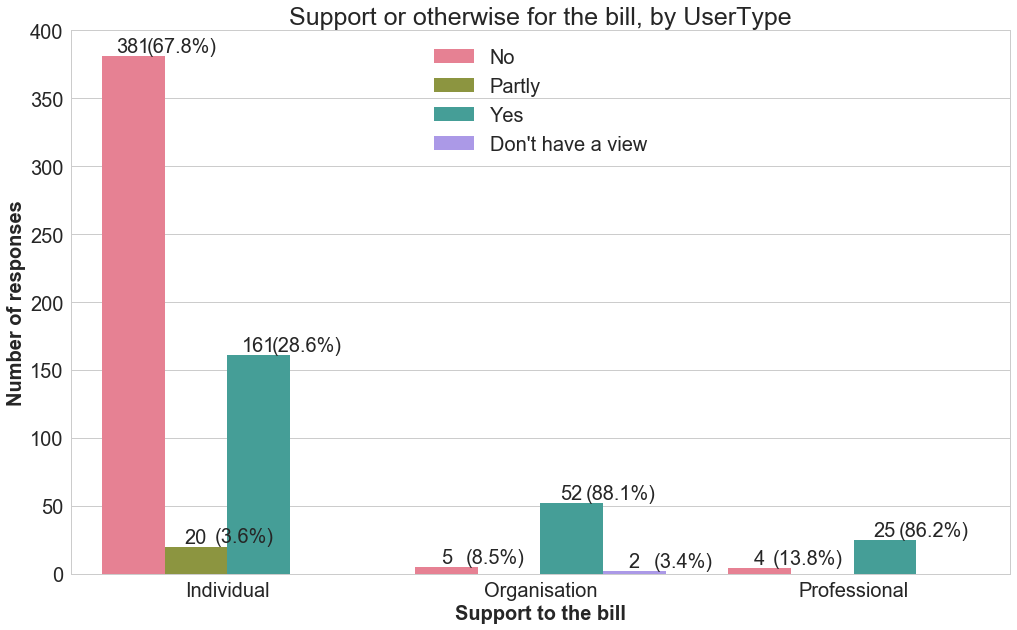

In [8]:
df_user_support=pd.DataFrame(df_responses_type.groupby(['UserType','BillSupport'])['Number of responses'].apply(sum))


df_user_support=df_user_support.reset_index()

users_list=list(np.unique(df_user_support['UserType']))



list_dfs=[df_user_support[df_user_support['UserType']==x] for x in users_list]

list_dfs_sum=[np.sum(x['Number of responses']) for x in list_dfs]

for x in range(len(list_dfs)):
    
    list_dfs[x]['Total']=list_dfs_sum[x]
    
    
list_dfs_all=pd.concat(list_dfs)

list_dfs_all['Percentage of responses(%)']=np.round(100*list_dfs_all['Number of responses']/list_dfs_all['Total'],1)

list_dfs_all=list_dfs_all.groupby(['UserType','BillSupport'])\
['Number of responses','Percentage of responses(%)'].apply(sum)

list_dfs_all.to_excel(path_to_results+'bill_support_each_strata.xlsx')

list_dfs_all=list_dfs_all.reset_index()


plt.figure(figsize=fig_siz_big)
ax=sns.barplot(x='UserType',y='Number of responses', hue="BillSupport", data=list_dfs_all,palette='husl')

plt.title('Support or otherwise for the bill, by UserType', fontsize=fnt_sz_title)
plt.xlabel('Support to the bill', fontsize = fnt_sz)
plt.ylabel('Number of responses', fontsize = fnt_sz)
plt.xticks(fontsize=fnt_sz)
plt.yticks(fontsize=fnt_sz)
plt.legend(fontsize=fnt_sz,loc='best')
totals=[]

for i in ax.patches:
    totals.append(i.get_height())
    
totals=[x for x in totals  if ~np.isnan(x)]
    

    
total=sum(totals)
for i in ax.patches:
    if ~np.isnan(i.get_height()):
        ax.text(i.get_x()+0.1,i.get_height()+0.04,str(int(i.get_height())),\
                ha = 'center', va='bottom',fontsize=fnt_sz)
        ax.text(i.get_x()+0.255,i.get_height()+0.095,'('+str(list(list_dfs_all[list_dfs_all['Number of responses']==i.get_height()]['Percentage of responses(%)'])[0])+'%)',ha = 'center', \
                                                            va='bottom',fontsize=fnt_sz)
plt.savefig(path_to_results+'each_strata_bill_support_percent.png')
plt.show()



##### Step 3.4: Collating responses to all the questions based on support or otherwise for the Bill (ignoring the user types)



In [10]:
typ_respons=list(set(consultn_data['BillSupport']))

#typ_respons=['No', 'Yes', 'Partly', "Don't have a view"]

#Look at the responses to the Questions in light of their response whether they support the bill or not.

consultn_data_types_list=[consultn_data[consultn_data['BillSupport']==x]\
                          for x in typ_respons]

consultn_data_types_list_shrt=[]

respons_12=[]
respons_13=[]
respons_21=[]
respons_22=[]
respons_31=[]
respons_41=[]
respons_51=[]

for index in range(len(consultn_data_types_list)):
    
    list_columns=['BillSupport',\
                  'Q10 12 Please outline your reasons for your answer to question',\
                  'Q11 13 Do you think there is a need for legislation to deliver',\
                  'Q12 21 Do you have any comments about any potential barriers t',\
                  'Q13 22 Do you think the Bill takes account of these potential ',\
                  'Q14 31 Do you think there are there any unintended consequence',\
                  'Q15 41 Financial Implications', 'Q16 51 Other Comments']
    consultn_data_types_list[index][list_columns]=consultn_data_types_list[index][list_columns].astype(str)
    consultn_data_types_list_shrt.append(consultn_data_types_list[index][list_columns])
    respons_12.append('/~~/'.join(consultn_data_types_list[index][list_columns[1]].values))
    respons_13.append('/~~/'.join(consultn_data_types_list[index][list_columns[2]].values))
    respons_21.append('/~~/'.join(consultn_data_types_list[index][list_columns[3]].values))
    respons_22.append('/~~/'.join(consultn_data_types_list[index][list_columns[4]].values))
    respons_31.append('/~~/'.join(consultn_data_types_list[index][list_columns[5]].values))
    respons_41.append('/~~/'.join(consultn_data_types_list[index][list_columns[6]].values))
    respons_51.append('/~~/'.join(consultn_data_types_list[index][list_columns[7]].values))

all_responses=[respons_12,respons_13,respons_21,respons_22,respons_31,respons_41,respons_51]

dict_abvn = {'ASAP':'as-soon-as-possible','asap': 'as-soon-as-possible', 'AFAIK': 'as-far-as-I-know',\
     'AFAIK': 'as-far-as-I-know','fta': 'free-trade-agreement','eu': 'european-union','EU': 'european-union',\
     'the us': 'united states','the US': 'united states','ukeu':'uk-and-eu','uk-eu':'uk-and-eu','UK-EU':'uk-and-eu',\
    'united states': 'united states','united kingdom': 'united kingdom','nhs':'national-health-service',\
            'NHS':'national-health-service','child on child violence':'child-on-child violence',\
             'child on child':'child-on-child','child child violence':'child-on-child violence',\
             'child child abuse':'child-on-child abuse'}

##### Step 3.5: Perform text cleaning on responses to all the questions based on support or otherwise for the Bill (ignoring the user types)

In [11]:


#numb_support_bill=df_responses.shape[0]

numb_support_bill=len(list(set(df_responses_type['BillSupport'])))
if list(set([len(all_responses[x])==numb_support_bill for x in range(len(all_responses))]))[0]:
    print('OK')
else:
    print('not-OK')
    




#expand contractions

def expand_contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


pattern=re.compile('^\s+|\s*,\s*|\s+$')

def remove_spaces(y):
    chck=[x for x in pattern.split(y) if x]
    return chck



#re.sub('\s+', ' ',all_responses[0][0].split('/~~/')[0].replace('\x92',"\'"))#encode('utf-8').decode('utf-8')

Questn_0='Please outline your reasons for your support of the principles of the children abolition \
of defence of reasonable punishment wales bill'



Questn_1='Do you think there is a need for legislation to deliver what children abolition \
of defence of reasonable punishment wales bill is trying to achieve'




Questn_2='Do you have any comments about any potential barriers to implementing the\
children abolition of defence of reasonable punishment wales bill'


Questn_3='Do you think the children abolition of defence of reasonable punishment wales bill takes account of \
these potential barriers'


Questn_4='Do you think there are any unintended consequences arising from the \
children abolition of defence of reasonable punishment wales bill'


Questn_5='Do you have any comments on the financial implications of the \
children abolition of defence of reasonable punishment wales bill'




Questn_6='Do you have any other points you wish to raise about the \
children abolition of defence of reasonable punishment wales bill'



questn_asked=[Questn_0,Questn_1,Questn_2,Questn_3,Questn_4,Questn_5,Questn_6]



questn_asked_short=['reasons for your support ?','need for legislation ?','potential barriers ?',\
                    'takes account of barriers ?','any unintended consequences ?',\
                   'financial implications ?','any other points ?']


list_questns=['Questn_'+str(x) for x in range(7)]

def get_lemma(word):
    lemma = wn.morphy(word,wn.NOUN)
    if lemma is None:
        return word
    else:
        return lemma



def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word,'v')

import string

def clean_doc(text_record):
    
    
    

    
    text_record_with_sentences=' '.join([get_lemma2(x.lower()) for\
                                         x in nltk.sent_tokenize(text_record)])
    
    text_record_with_sentences=re.sub('[^a-zA-Z0-9.]+',' ',text_record_with_sentences)
    
    #remove punct. except itra word hyphen
    p = re.compile(r"(\b[-']\b)|[\W_]")
    text_record= p.sub(lambda m: (m.group(1) if m.group(1) else " "),text_record)
    
    
    

    tokens = text_record.split()
    
    # convert letters to lower case
    tokens = [token.lower() for token in tokens]
    
    #tokens = [token for token in tokens if not token.isdigit()]
    
    

    tokens_no_stpwrds = [get_lemma2(token) for token in tokens]
    
    
    
    tokens = [token for token in tokens if len(token) > 3]
    
    
    
    tokens= [get_lemma2(token) for token in tokens]
    
    tokens_copy = [token for token in tokens]
    
    #tokens= [porter_stemmer.stem(token) for token in tokens]
    
    tokens = [token for token in tokens if token not in stop_words]
    
    
    
    
    
    sentence = ' '.join(tokens)
    
    
    
    sentence_copy = ' '.join(tokens_copy)
    
    sentence_no_stop_words=' '.join(tokens_no_stpwrds)
    
    #print(sentence_no_stop_words)
    return sentence,sentence_no_stop_words,text_record_with_sentences,sentence_copy






# the simplest, lambda-based implementation
def multiple_replace(adict, text):
  # Create a regular expression from all of the dictionary keys
  regex = re.compile("|".join(map(re.escape, adict.keys(  ))))

  # For each match, look up the corresponding value in the dictionary
  return regex.sub(lambda match: adict[match.group(0)], text)





        

str_responses=[[]]*numb_support_bill

str_responses_copy=[[]]*numb_support_bill

str_responses_no_stpwrds=[[]]*numb_support_bill
str_responses_no_stpwrds_sentences=[[]]*numb_support_bill

#Text-cleaning
for index in range(numb_support_bill):
    temp=[]
    temp_copy=[]
    temp_no_stpwrds=[]
    temp_no_stpwrds_sentences=[]
    for secnd_index in range(len(all_responses)):
        data=all_responses[secnd_index][index].split('/~~/')
        data=[x for x in data if (x!='-') & (x!='nan')&(len(x)!=0)]
        
        data=[x.replace('\x92',"\'") for x in data]
        
        
        
        
        # Remove Emails
        data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
        
        #Remove websites
        
        #data=[re.sub(r'^https?:\/\/.*[\r\n]*','',sent) for sent in data]
        
        data=[re.sub(r'http\S+','',sent) for sent in data]

        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]

        # Remove distracting single quotes
        #data = [re.sub("\'", "", sent) for sent in data]
        
        
        data=[expand_contractions(sent) for sent in data]
        
        
        #make a mapping of words from lookup dictionary

        #data_unclean=[''.join( dict_abvn.get( word, word ) for word in re.split( '(\W+)', x ) ) for x in data]
        
        
        
        
        

        
        
        data_unclean=[nltk.sent_tokenize(x) for x in data]
        
        
        
        
        #print(data_unclean)
        data = [[clean_doc(comment)[0] for comment in y] for y in data_unclean]
        
        
        data_copy = [[clean_doc(comment)[3] for comment in y] for y in data_unclean]
        
        
        data_no_stpwrds = [[clean_doc(comment)[1] for comment in y] for y in data_unclean]
        
        
        data_no_stpwrds_sentences = [[clean_doc(comment)[2] for comment in y] for y in data_unclean]
        
        
        
        data = [[x for x in y if len(x)!=0] for y in data]
        
        data_copy = [[x for x in y if len(x)!=0] for y in data_copy]
        
        data_no_stpwrds = [[x for x in y if len(x)!=0] for y in data_no_stpwrds]
        
        data_no_stpwrds = [[x for x in y if len(x)!=0] for y in data_no_stpwrds_sentences]
        
        
        data=[[multiple_replace(dict_abvn,x) for x  in y] for y in data]
        
        data_copy=[[multiple_replace(dict_abvn,x) for x  in y] for y in data_copy]
        data_no_stpwrds=[[multiple_replace(dict_abvn,x) for x  in y] for y in data_no_stpwrds]
        data_no_stpwrds_sentences=[[multiple_replace(dict_abvn,x) for x  in y] for y in data_no_stpwrds_sentences]
        
        
        #print(len(data))
        #data=','.join(data)
        temp.append(data)
        temp_copy.append(data_copy)
        temp_no_stpwrds.append(data_no_stpwrds)
        temp_no_stpwrds_sentences.append(data_no_stpwrds_sentences)
        
    #temp='/~~/'.join(temp)
    str_responses[index]=temp
    str_responses_copy[index]=temp_copy
    str_responses_no_stpwrds[index]=temp_no_stpwrds
    str_responses_no_stpwrds_sentences[index]=temp_no_stpwrds_sentences
        



combined_responses_all_questns=[]
combined_responses_all_questns_copy=[]
combined_responses_all_questns_no_stpwrds=[]
combined_responses_full_sentences=[]
for x in range(len(str_responses)):
    for y in range(len(questn_asked)):
        
        temp=[item for sublist in str_responses[x][y] for item in sublist]
        
        temp_copy=[item for sublist in str_responses_copy[x][y] for item in sublist]
        
       
        
        
        temp_no_stpwrds=[item for sublist in str_responses_no_stpwrds[x][y] for item in sublist]
        
        
        temp_full_statment=[' '.join(x).strip() for x in str_responses_no_stpwrds_sentences[x][y]]
        
        
        combined_responses_all_questns.append(temp)
        
        combined_responses_all_questns_copy.append(temp_copy)
        
        combined_responses_all_questns_no_stpwrds.append(temp_no_stpwrds)
        
        combined_responses_full_sentences.append(temp_full_statment)
    
    
#combined_responses_all_questns=[[x for x in y if len(x.split(' '))>=allowed_sentenc] for y in combined_responses_all_questns]




len(combined_responses_all_questns_copy)



def gen_bi_trigram_key_wrds(rspns_list,minm_count,thrsh):
    
    docmnt_list=rspns_list
    mincnt=minm_count
    sentence_stream = [doc.split(" ") for doc in docmnt_list]#train_documents]
    bigram = Phrases(sentence_stream, min_count=mincnt,delimiter=b' ',threshold=thrsh)
    trigram = gensim.models.Phrases(bigram[sentence_stream],min_count=mincnt,delimiter=b' ',threshold=thrsh) 


    bigrams_ = [[b for b in bigram[sent] if b.count(' ') == 1] for sent in sentence_stream]
    bigrams_ = [item for sublist in bigrams_ for item in sublist]
    trigrams_ = [[t for t in trigram[bigram[sent]] if t.count(' ') == 2] for sent in sentence_stream]
    trigrams_ = [item for sublist in trigrams_ for item in sublist]
    bigrams_=[b for b in bigrams_ if all(b not in t for t in trigrams_)]
    combined_list=bigrams_+trigrams_
    flat_list=combined_list
    return flat_list
#flat_list=combined_list



OK


##### Step 3.6: Finding most frequent word collocation phrases  and their context appearing in responses in support or otherwise for the Bill



<Figure size 432x288 with 0 Axes>

<Figure size 2520x1296 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 2520x1296 with 0 Axes>

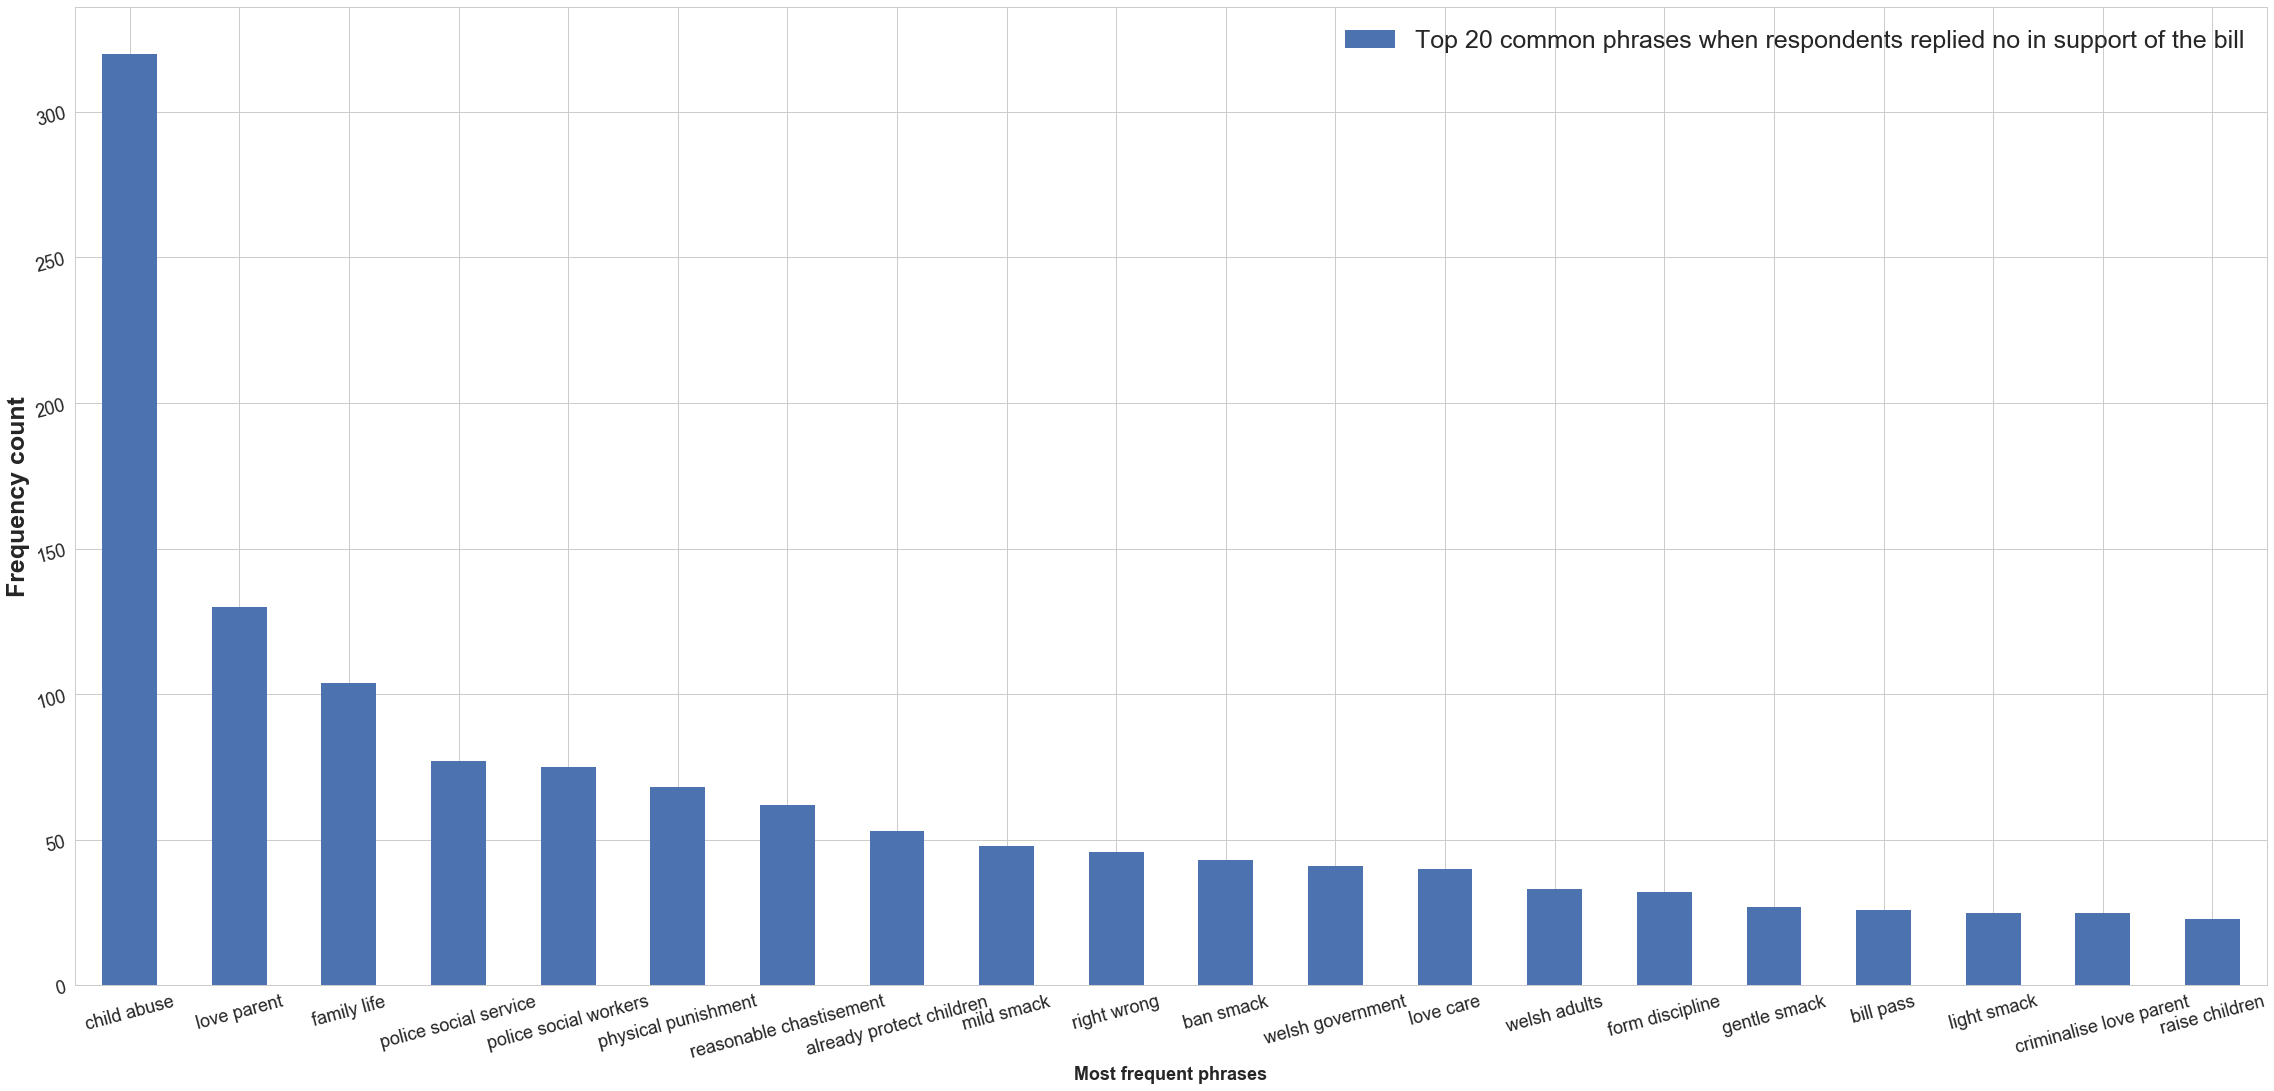

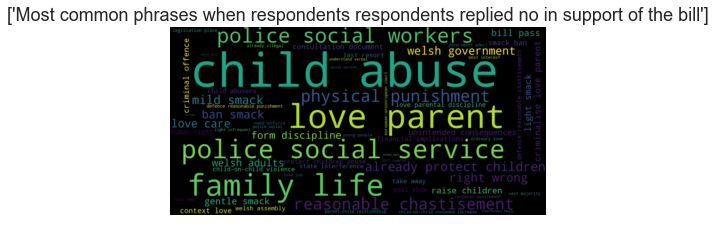

<Figure size 432x288 with 0 Axes>

<Figure size 2520x1296 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 2520x1296 with 0 Axes>

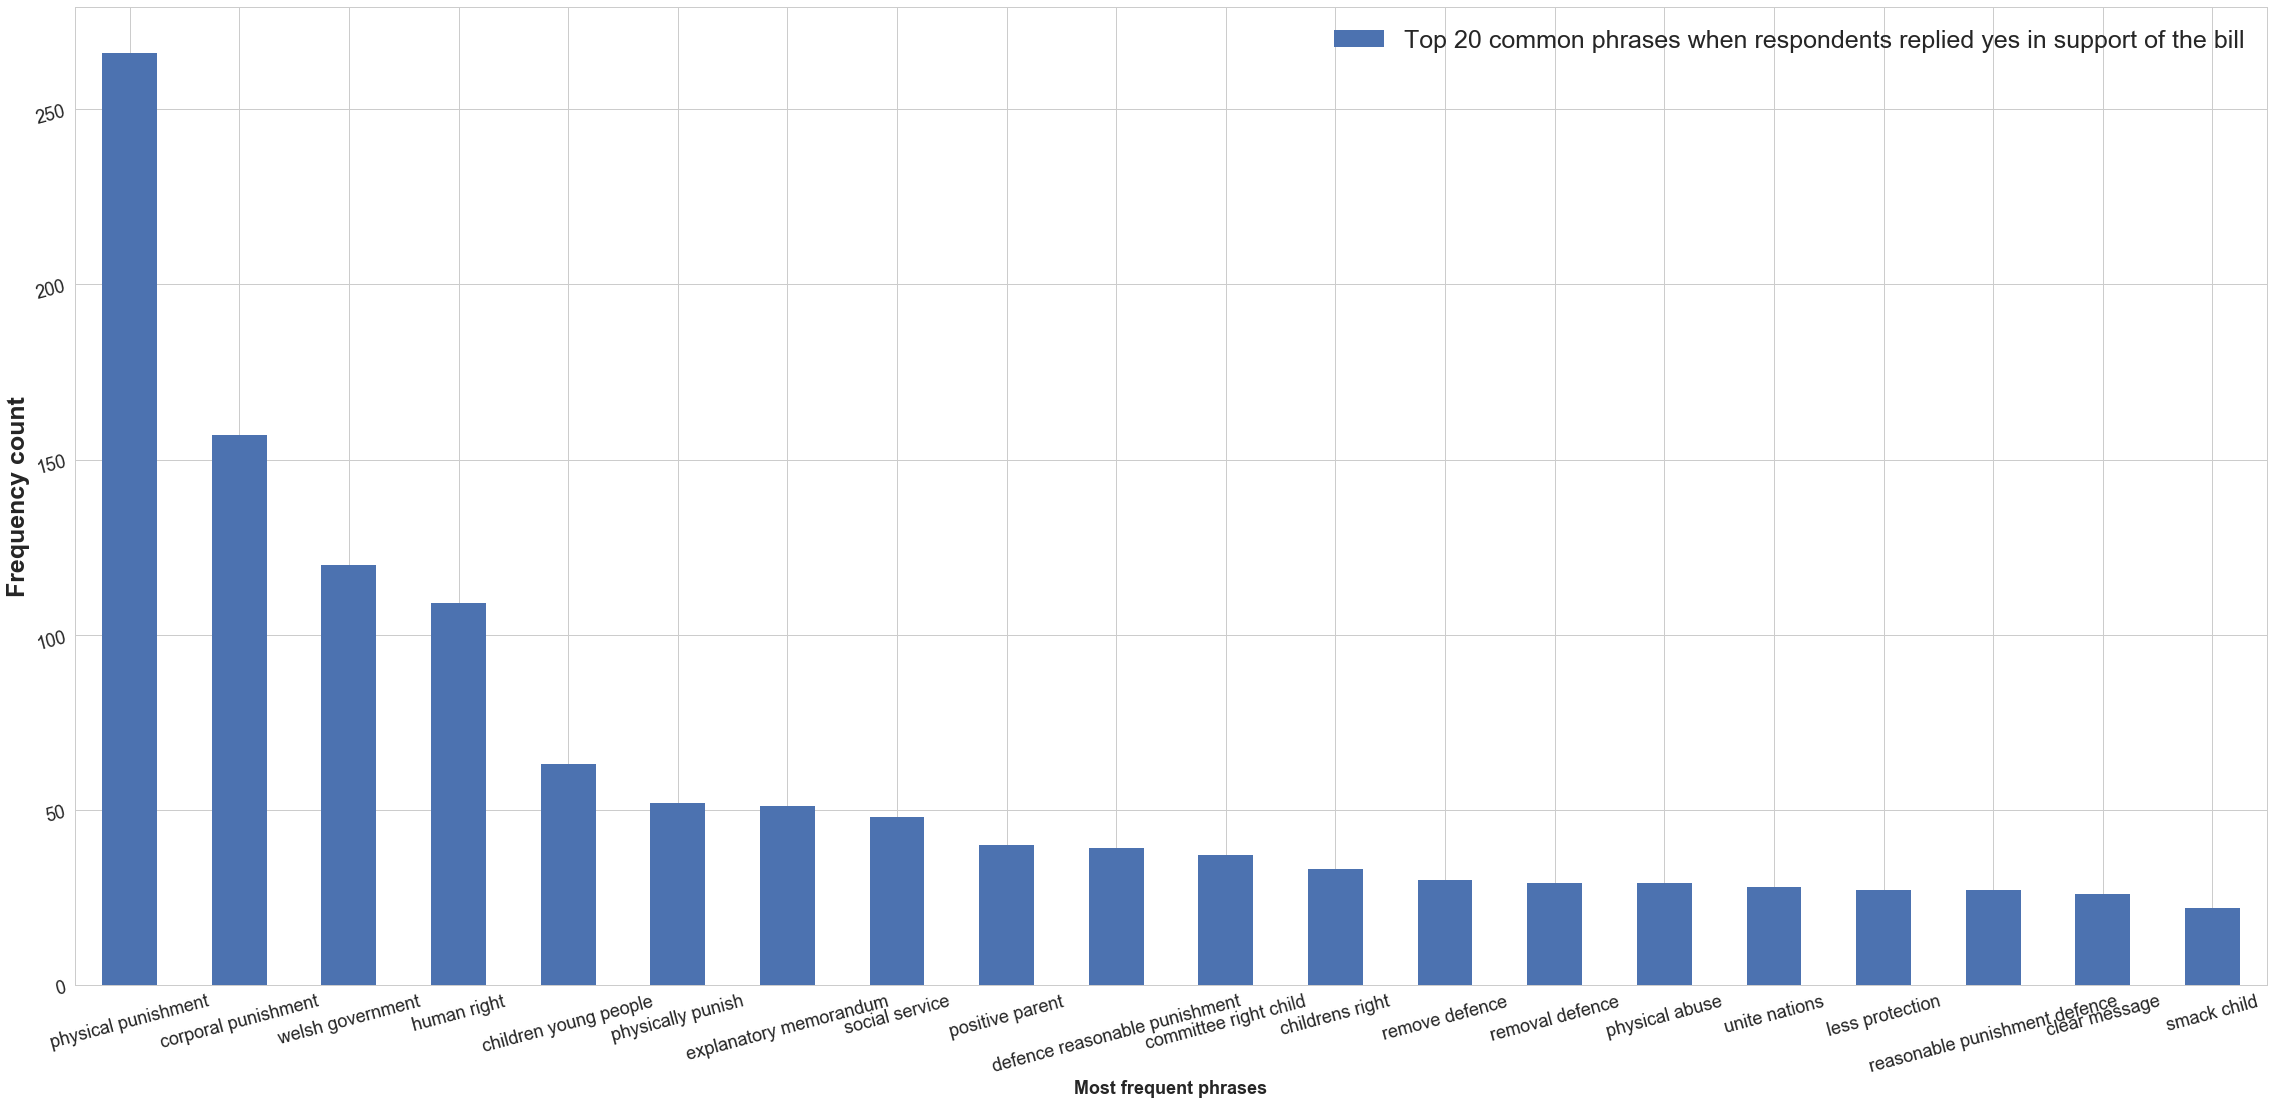

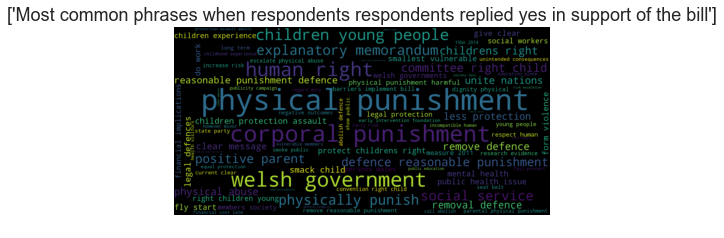

In [17]:
min_occur=10
thrshld=5
str_responses_key_wrds=[0]*len(typ_respons)
for index in range(len(typ_respons)):
                                             
    str_temp=[]
    for qustn_indx in range(len(questn_asked)):
        data=combined_responses_all_questns[len(questn_asked)*index:len(questn_asked)*(index+1)][qustn_indx]
        temp=gen_bi_trigram_key_wrds(data,min_occur,thrshld)
        str_temp.append(temp)
    str_temp=[item for sublist in str_temp for item in sublist]
          
    str_responses_key_wrds[index]=str_temp

    
    
    
flat_list_all_keywrds=str_responses_key_wrds





# we can override the default parameters
fnt_sz=18


fnt_sz_big=25

fnt_sz_tk=15

fnt_sz_tk_big=12

fnt_sz_legend_big=12 
fig_siz=(10,5)
fig_siz_big=(35,18)





rotn_tld=15


#Getting the most frequent words in each response type

top_words=100

top_few_words=20

WC_height = 1000
WC_width = 2000
WC_max_words = 100



for index in range(len(typ_respons)):
    
    freq_flat_list=nltk.FreqDist(flat_list_all_keywrds[index])
    
    word_dict={}
    ordered_list=sorted(freq_flat_list.items(),key=operator.itemgetter(1),reverse=True)








    freq_dis_plot = plt.figure()

    plt.figure(figsize=fig_siz_big)
    df=pd.DataFrame(freq_flat_list.most_common(top_words))
    
    
    if df.shape[0]!=0:
        df.columns=['Key phrases', 'Counts']
        df.to_csv(path_to_results+'most_frequent_'+str(typ_respons[index])+'.csv')
        df=df.head(top_few_words)
        df.plot(x='Key phrases',y='Counts',kind='bar',figsize=fig_siz_big)
        plt.xlabel('Most frequent phrases', fontsize = fnt_sz)
        plt.ylabel('Frequency count', fontsize = fnt_sz_big)
        plt.legend(['Top {} common phrases when respondents replied {} in support of the bill'\
                .format(str(top_few_words),str(typ_respons[index]).lower())],fontsize = fnt_sz_big)
        plt.xticks(fontsize=fnt_sz,rotation=rotn_tld)
        plt.yticks(fontsize=fnt_sz,rotation=rotn_tld)
        plt.savefig(path_to_results+'most_frequent_count_'+'_'+str(typ_respons[index]).lower()+'.png')
        
        
        plt.show()
        wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
        wordCloud.generate_from_frequencies(dict(ordered_list))
        plt.title(['Most common phrases when respondents respondents replied {} in support of the bill'\
                .format(str(typ_respons[index]).lower())],fontsize = fnt_sz)
        plt.imshow(wordCloud, interpolation='bilinear')
        plt.axis("off")
        wordCloud.to_file(path_to_results+'word_cloud_most_frequent_count_'+'_'+str(typ_respons[index]).lower()+'.png')
        #plt.show()


##### Step 3.7:Finding salient phrases (using tf-idf)  in all the responses in support or otherwise for the Bill

In [14]:




for which in typ_respons:
    top_n=top_few_words
    index_chsen=[x for x,y in enumerate(typ_respons) if y==which][0]



    if os.path.isfile(path_to_results+'most_frequent_'+str(which)+'.csv'):
        df_key_wrd=pd.read_csv(path_to_results+'most_frequent_'+str(which)+'.csv')
        
        df_key_wrd=df_key_wrd.head(top_n)
    
        lst_ky_wrds=list(df_key_wrd['Key phrases'])

        print(index_chsen)

#ky_wrd='police social service'

        str_context_all=[]
        str_df_key_top_n=pd.DataFrame()
        for out_indx in range(len(lst_ky_wrds)):
            str_tmp=[]
            for indx in range(len(questn_asked)):
                flat_respns=[item for sublist in str_responses_no_stpwrds[index_chsen][indx] for item in sublist if item!=[]]
    
        #print(lst_ky_wrds[out_indx])
                str_context=[item for item  in flat_respns if re.search(lst_ky_wrds[out_indx],' '.join([ get_lemma2(x) for x in item.split()\
                                                                                                if x not in stop_words]))]
        
                str_context=[item for item  in str_context if item!=[]]
                tmp=str_context
                str_tmp.append(tmp)
            str_tmp=[item for sublist in str_tmp for item in sublist if item!=[]]
            str_context_all.append(str_tmp)
        
        pd.set_option('display.max_colwidth',-1)
        str_df_key_top_n['Frequent Phrases']=['----'.join(x) for x in str_context_all]

        str_df_key_top_n['Keywords']=lst_ky_wrds

        str_df_key_top_n['Support to the bill']=[str(which)]*len(lst_ky_wrds)

        str_df_key_top_n.to_html(path_to_results+'key_phrases_'+str(which)+'.html')

1
3


In [31]:
# Parameters for tf-idf
max_cnt=0.1# (ignore phrases present in more than 10% of the responses)
min_cnt=5 # (ignore phrases present in more than 5 of the responses)

top_n=20


min_cnt_mean=0.25



In [32]:
# a function that takes a single row of the tf-idf matrix 
#(corresponding to a particular document), 
# and return the n highest scoring words 
#(or more generally tokens or features):
#top_tfidf_feats(train_unigrams.toarray()[0,:],
#features, top_n)
def top_tfidf_feats(row, features, top_n):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df



#The result of a tf-idf, however, is typically a sparse matrix, 
#which doesn’t support all the usual matrix or array operations. 
#So in order to apply the above function to inspect a particular document,
#we convert a single row into dense format first:
def top_feats_in_doc(Xtr, features, row_id, top_n):
    'Top tfidf features in specific document (matrix row)'
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)



# gives us the most important words across the whole corpus.
#Here are the top_n: Here, we provide a list of row indices which 
#pick out the particular documents we want to inspect. 
#Providing ‘None’ indicates, somewhat counterintuitively, that we’re 
#interested in all documents. We then calculate the mean of each column across the selected rows,
#which results in a single row of tf-idf values. And this row we then simply pass on to our previous
#function for picking out the top n words. 





def top_mean_feats(Xtr, features, grp_ids, min_tfidf=min_cnt_mean, top_n=top_n):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids,:].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


#What might be more interesting, though, is to separately consider
#groups of documents falling into a particular category. For example,
#let’s calculate the mean tf-idf scores
#depending on a document’s class label:

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=min_cnt_mean, top_n=top_n):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=subtypes
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, list(ids), min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

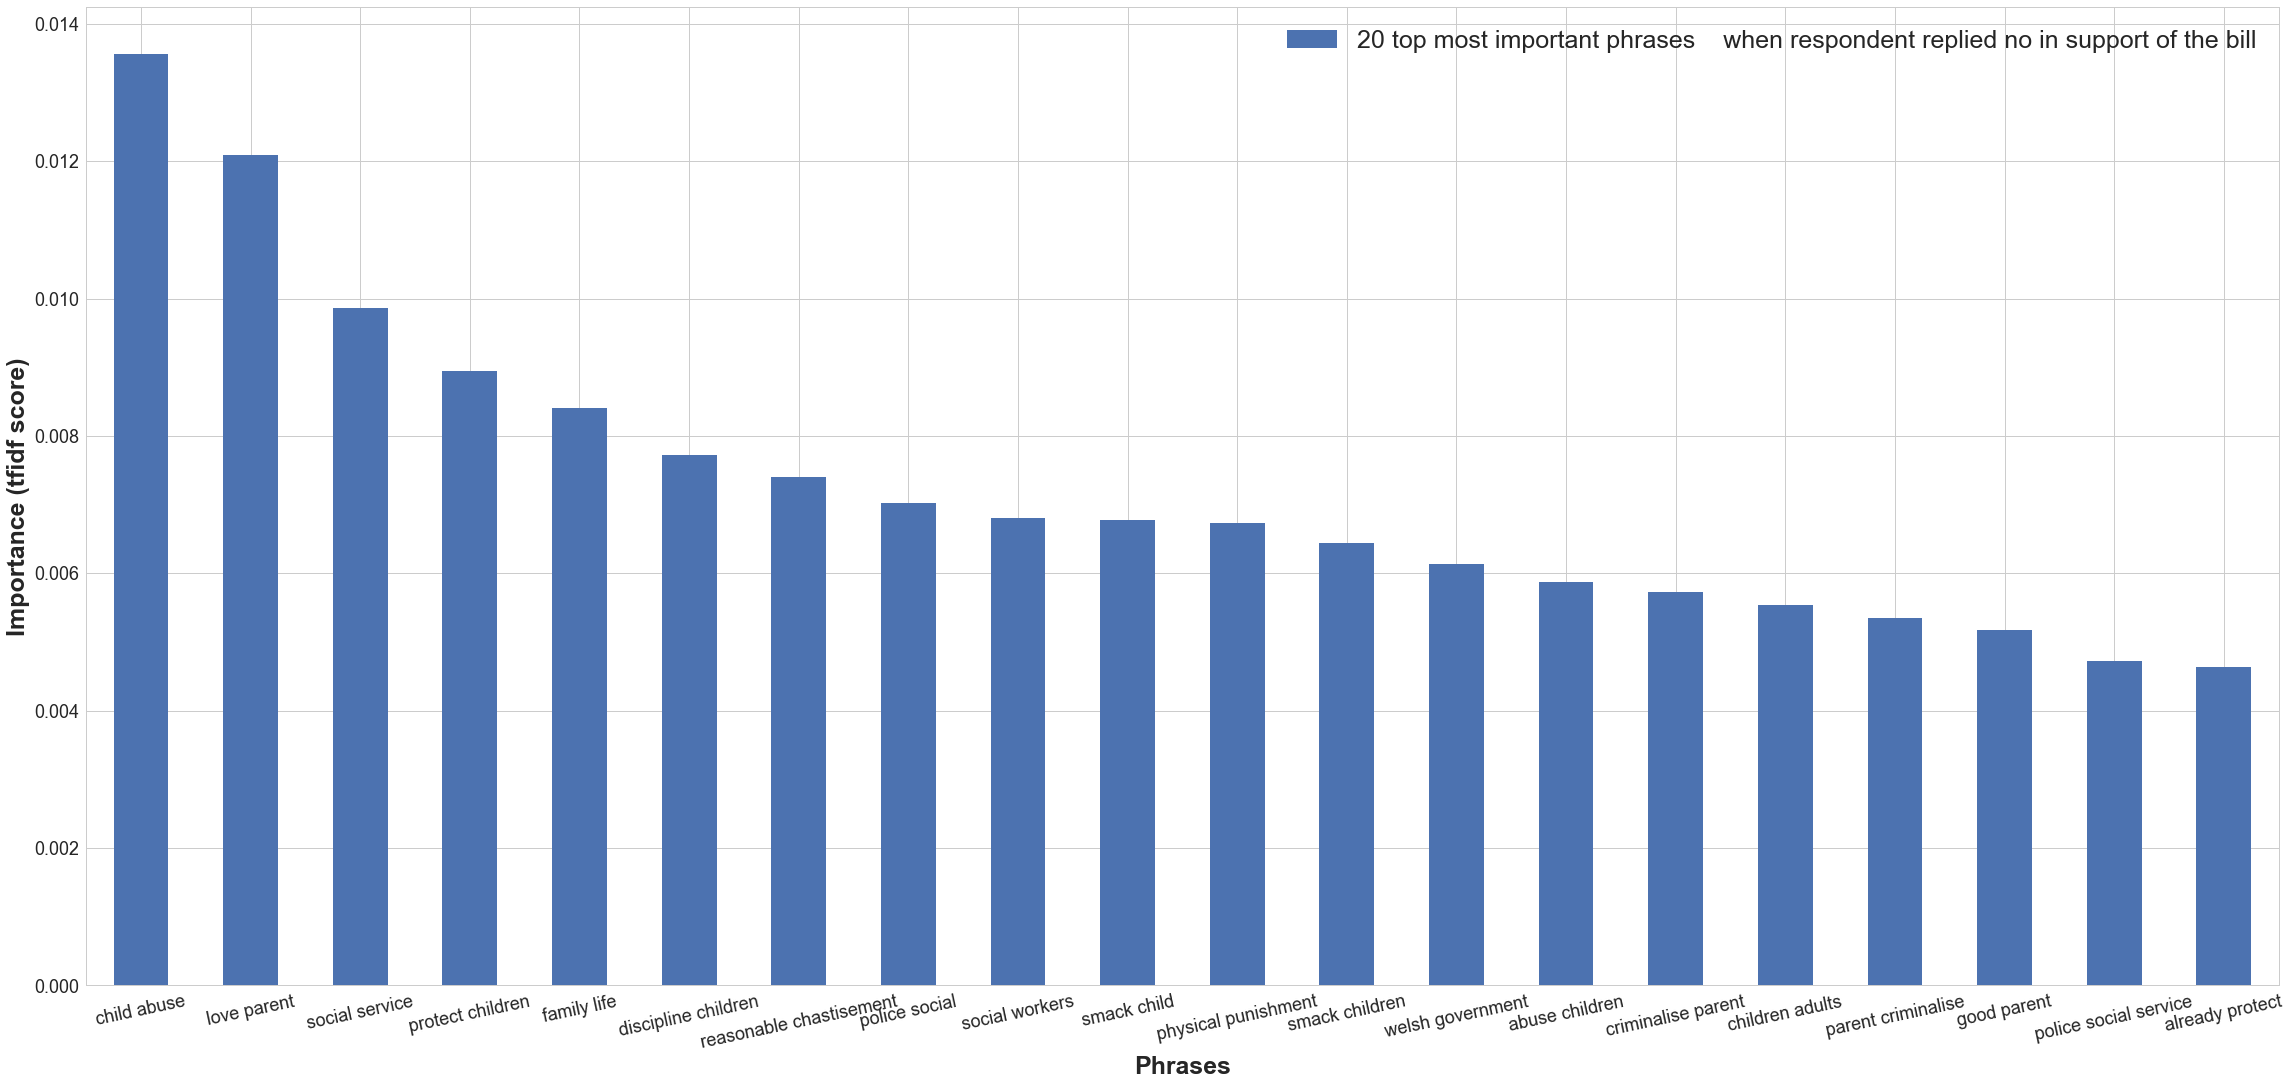

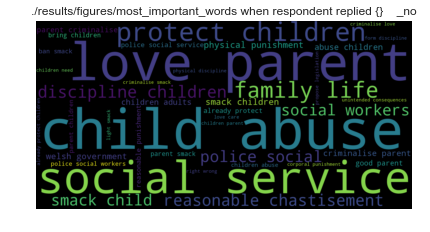

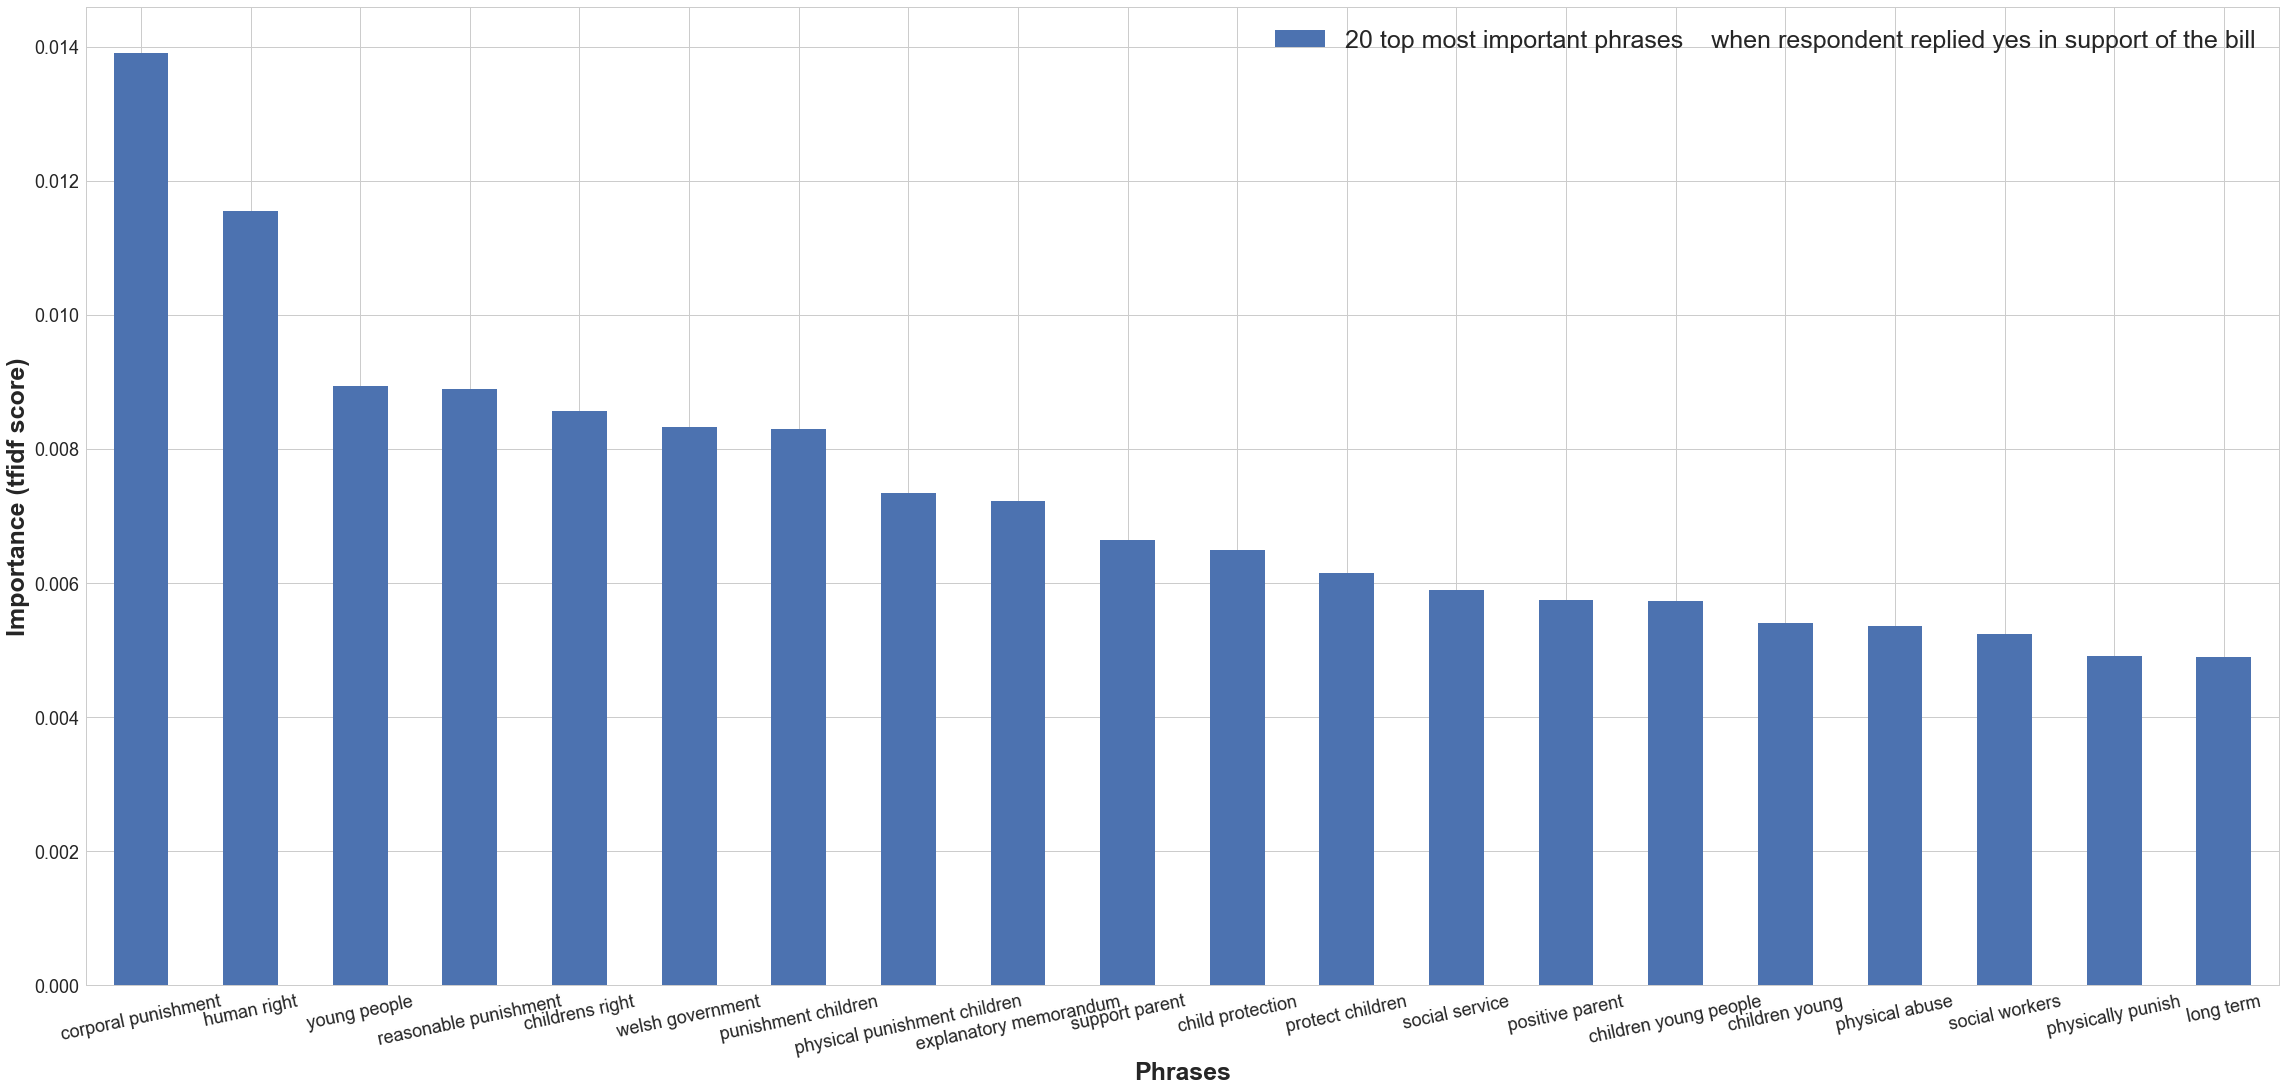

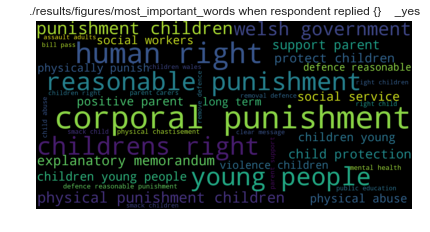

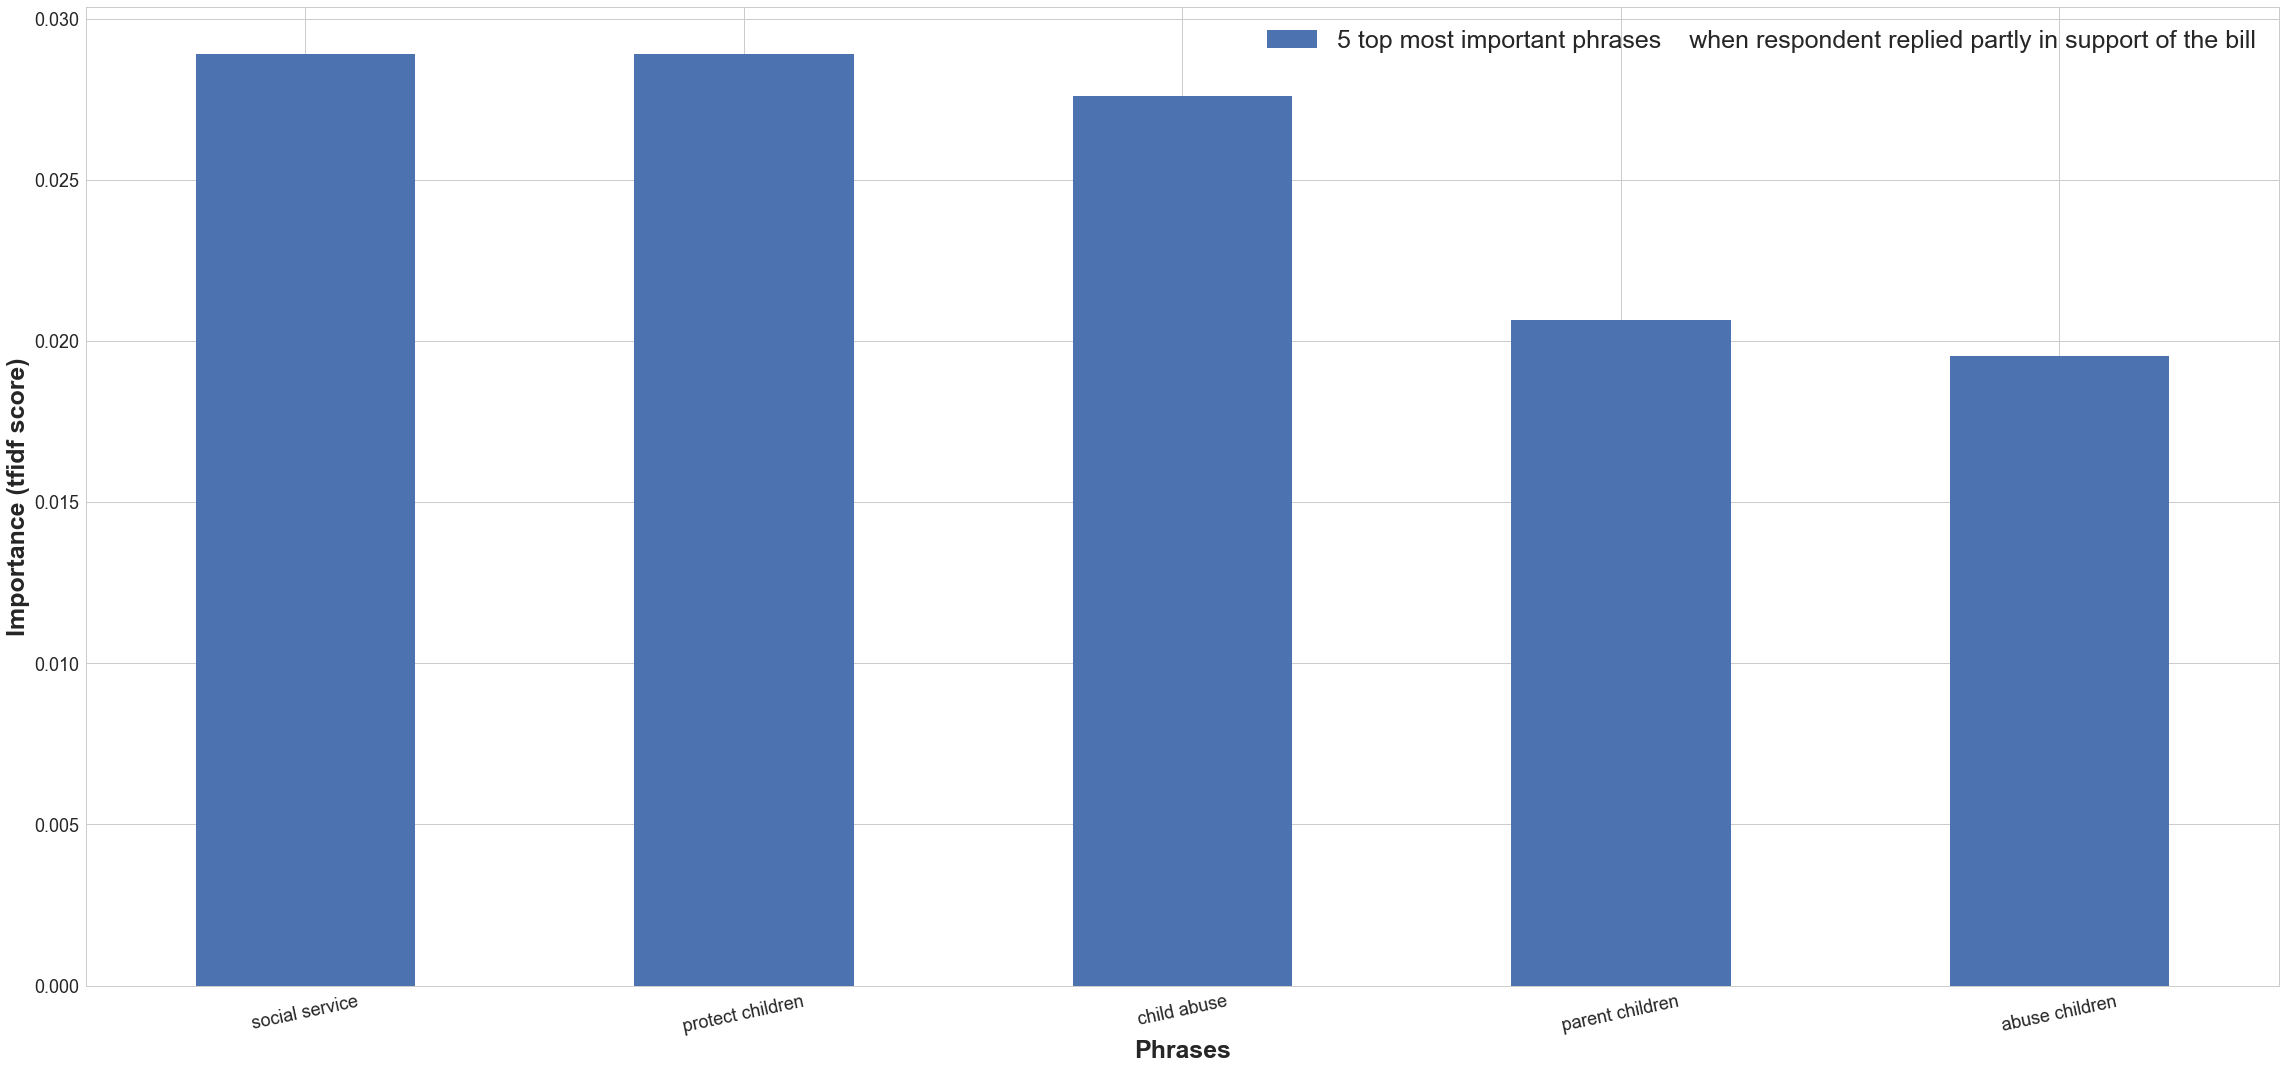

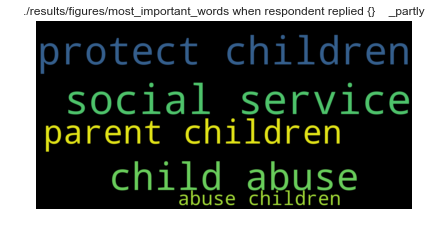

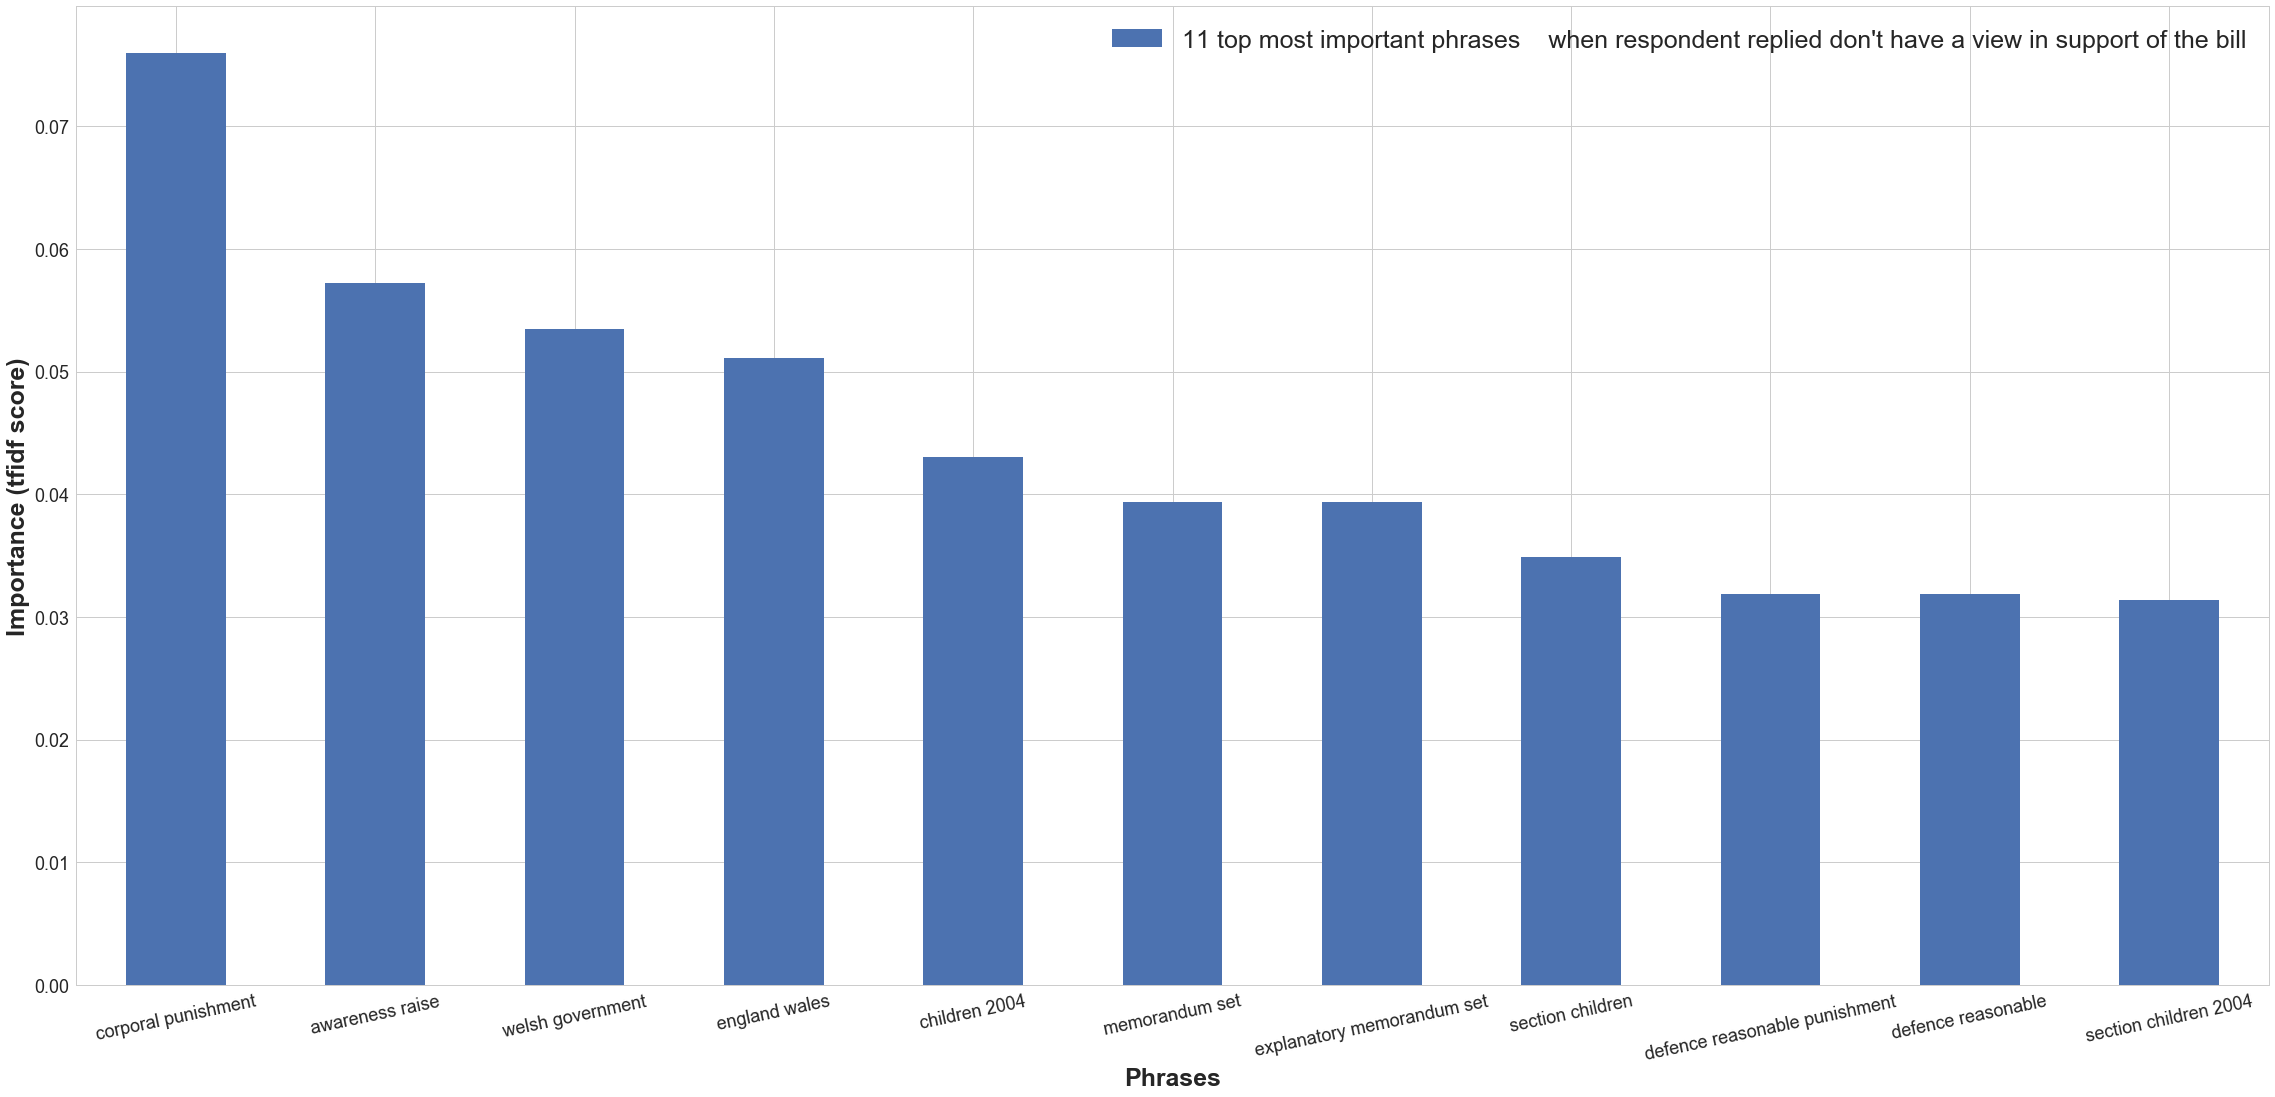

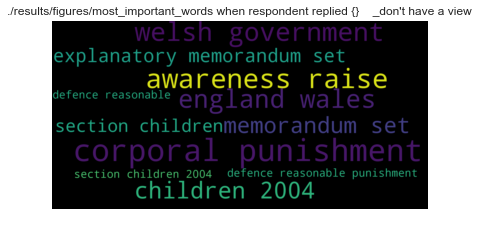

In [35]:
rotn_tld_2=12

for index in range(len(typ_respons)):
    
    #respons=combined_responses_all_questns[index]
    
    
    respons=[item for sublist in combined_responses_all_questns[len(questn_asked)*index:len(questn_asked)*(index+1)] for \
            item in sublist]
    clean_corpus=pd.DataFrame(respons)
    
    
    
    tfv = TfidfVectorizer(max_df=max_cnt,min_df=min_cnt,  max_features=None, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,3),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_words)

    tfv.fit(clean_corpus[clean_corpus.columns[0]])
    features = np.array(tfv.get_feature_names())
    train_ngrams =  tfv.transform(clean_corpus[clean_corpus.columns[0]].ravel())
    
    
    
    
    
    most_imp_wrds_df=top_mean_feats(train_ngrams, features, None, min_tfidf=min_cnt_mean, top_n=2*top_n)
    
    most_imp_wrds_df=most_imp_wrds_df[most_imp_wrds_df['tfidf']!=0]

    most_imp_wrds_df_copy=most_imp_wrds_df.head(top_n)

    most_imp_wrds_df_copy.plot(x='feature',y='tfidf',kind='bar',figsize=fig_siz_big)
    
    
     

    plt.xlabel('Phrases', fontsize = fnt_sz_big)
    plt.ylabel('Importance (tfidf score)', fontsize = fnt_sz_big)
    plt.legend(['{} top most important phrases\
    when respondent replied {} in support of the bill'.\
                format(most_imp_wrds_df_copy.shape[0],str(typ_respons[index]).lower())],fontsize = fnt_sz_big)
    plt.xticks(fontsize=fnt_sz,rotation=rotn_tld_2)
    plt.yticks(fontsize=fnt_sz)
    
    plt.savefig(path_to_results+'top {} most_important_words when respondent replied {}\
    in support of the bill'.format(most_imp_wrds_df.shape[0],str(typ_respons[index]).lower()))
    
    plt.show()
    
                
    from wordcloud import WordCloud
    old_dic=dict(zip(most_imp_wrds_df.feature,list(most_imp_wrds_df.tfidf)))
    new_dic = {k:v for k,v in old_dic.items() if v != 0}
    
    wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
    wordCloud.generate_from_frequencies(new_dic)
    plt.title(path_to_results+'most_important_words when respondent replied {}\
    '+'_'+str(typ_respons[index]).lower())
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    #wordCloud.to_file(path_to_results+'word_cloud_most_imp_count_'+'_'+str(typ_respons[index]).lower()+'.png')
    
    wordCloud.to_file(path_to_results+'word_cloud_most_important_words_'+'_'+str(typ_respons[index]).lower()+'.png')
    




    


